# Procedural monomer fragment generation using rules-based reactions

In constructing polymer systems for MD, there are a handful of core issues that one will frequently encounter:
* When working with polymers, it is virtually always the case that the repeat units in a polymer chain are _not_ chemically identical to the corresponding monomers  
* Also, when setting up polymeric systems for MD, particularly for high-throughput applications, it is desireable to set up many functionally-similar monomers which follow the same polymerization mechanism
* Finally, the [monomer fragment specification we prescribe](https://pubs.acs.org/doi/10.1021/acs.jcim.3c01691) can be a bit unwieldy and tough to parse, and generating these fragment template by hand is error-prone

With these facts in mind, the polymerist toolkit provides utilities which remedy all of the above, demonstrated here

In [ ]:
from rdkit import Chem
from IPython.display import display

from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path

RXNS_DIR = Path('rxn_demo_files')
RXNS_DIR.mkdir(exist_ok=True)

# Example 1: conjugation of thiophenes with linear alkyl tails (head-to-tail)

In [ ]:
example_dir_1 = RXNS_DIR / 'polythiophene'
example_dir_1.mkdir(exist_ok=True)

### Defining reactant templates and side products

In [ ]:
from polymerist.rdutils import rdkdraw
from polymerist.polymers.monomers.specification import expanded_SMILES, SANITIZE_AS_KEKULE


rdkdraw.set_rdkdraw_size(200, 3/2)
dihydrogen = Chem.MolFromSmarts('[H]-[H]') # this is a reaction byproduct; these need to be explicitly defined on the template
template_smiles_raw = [ # these two templates describe singly-fragmented thiophenes with a single R-group on the 3-site and chain on the 2- and 4-sites, respectively
    'S1C=C(C=C1(*))*',
    'S1C(*)=C(C=C1)*',
] 

reactant_templates, template_smiles = [], []
for smiles in template_smiles_raw:
    exp_smiles = expanded_SMILES(smiles, assign_map_nums=False)
    template_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    Chem.SanitizeMol(template_mol, sanitizeOps=SANITIZE_AS_KEKULE)

    display(template_mol)
    template_smiles.append(exp_smiles)
    reactant_templates.append(template_mol)

### Assembling a reaction template

In [ ]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler


rdkdraw.set_rdkdraw_size(400, 3/2)
assem = ReactionAssembler(
    reactive_groups=reactant_templates,
    rxn_name='thiophene_conjugation',
)
display(assem.reactants)

This is where we define which bonds should move where (via closed bond cycles), and which byproducts (if any) should be washed away

In [ ]:
assem.bond_derangement = {
    8  : (7, 17), # H8 , which was connected to C7 , should reconnect to H17
    16 : (17, 7), # C16, which was connected to H17, should reconnect to C7
}
assem.byproducts = (dihydrogen,) # unmap the hydrogen byproduct, to avoid gumming up the reaction

Here we finally put together our reaction, watching first as all the old template bonds are broken and afterwards how all new bonds are formed

In [ ]:
from rdkit.Chem.rdChemReactions import (
    SanitizeRxn,
    SanitizeRxnAsMols,
    SanitizeFlags as SanitizeFlagsRxn
)


rxn = assem.assemble_rxn(show_steps=True)
SanitizeRxn(      rxn, sanitizeOps=SanitizeFlagsRxn.SANITIZE_ALL & ~SanitizeFlagsRxn.SANITIZE_MERGEHS) # perform all rxn clenup operations EXCEPT deleting hydrogens (we need those!)
SanitizeRxnAsMols(rxn, sanitizeOps=SANITIZE_AS_KEKULE) # removes aromatic flags from reactant and product templates
display(rxn)

rxn_path = assemble_path(example_dir_1, 'thiophene', extension='rxn')
rxn.to_rxnfile(rxn_path) # save reaction to file to use later

## Applying our reaction template to arbitrary monomers to enumerate chain fragments
Here you can specify **ANY** sidechain for the 3rd site of a thiophene; they can all be generated by the same reaction template  
This is the real power of the rules-based reaction approach; one template to rule them all (for a given polymerization mechanism)

### Defining reactive monomers (chemically identical to synthesis starting products)

In [ ]:
# Try out any sidechain with its SMILES!

# sidechain_smiles = '[H]' # bare thiophene
sidechain_smiles : str = 'CCCCCC'   # generic hexyl substituent (for poly(3-hexylthiophene) [P3HT])
# sidechain_smiles : str = 'c1ccccc1' # phenyl chain to show this works for aromatic groups
# sidechain_smiles = 'C1=NNN=N1' # tetrazole ring, to show this works for less common groups too :)

### Ensuring SMILES is chemically explicit and obtaining IUPAC name for chosen monomer

In [ ]:
from polymerist.smileslib.chemdbqueries import get_chemical_property


# produce chemically-complete monomer molecule representation
monomer_smiles = f'S1C=C(C=C1){sidechain_smiles}'
exp_monomer_smiles = expanded_SMILES(monomer_smiles, assign_map_nums=False)
monomer = Chem.MolFromSmiles(exp_monomer_smiles, sanitize=False)
Chem.SanitizeMol(monomer, sanitizeOps=SANITIZE_AS_KEKULE)

try:
    monomer_name = get_chemical_property('iupac_name', monomer_smiles, namespace='smiles')
    polymer_name = f'poly({monomer_name})'
except:
    polymer_name = 'polymer'
    
substituent_dir = example_dir_1 / polymer_name
substituent_dir.mkdir(exist_ok=True)

### Define head and tail monomers

In [ ]:
reactants_dict = {
    f'{monomer_name}_head' : monomer,
    f'{monomer_name}_tail' : monomer,
}
reactants = []
for reactant_name, reactant_mol in reactants_dict.items():
    print(  reactant_name)
    display(reactant_mol)
    reactants.append(reactant_mol)

### Load reaction template, create reactor, and test that the template works

In [ ]:
from polymerist.rdutils.reactions.reactions import AnnotatedReaction
from polymerist.rdutils.reactions.reactors import PolymerizationReactor


rxn = AnnotatedReaction.from_rxnfile(rxn_path) # notice here that we can use exactly he same RXN template, regardless of the chosen sidechain
reactor = PolymerizationReactor(rxn)
display(rxn)

for product in reactor.react(reactants):
    display(product)

### Enumerate all possible monomer fragments according to the defined polymerization reaction 

In [ ]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.polymers.monomers.specification import expanded_SMILES, compliant_mol_SMARTS


monogrp = MonomerGroup()
term_orient_labels : list[str] = ['head', 'tail']
rdkdraw.disable_substruct_highlights()
for dimers, fragments in reactor.propagate(reactants):
    for group_name, fragment in zip(reactants_dict.keys(), fragments):
        raw_smiles = Chem.MolToSmiles(fragment)
        exp_smiles = expanded_SMILES(raw_smiles)
        spec_smarts = compliant_mol_SMARTS(exp_smiles)
        
        if MonomerGroup.is_terminal(fragment):
            frag_name = f'poly-{group_name}_TERM'
            monogrp.monomers[frag_name] = [spec_smarts]
            # explicitly assign terminal group orientations (if this is not done, will assign
            # in order of appearance of end groups by default, and will alert you with a warning)
            if term_orient_labels: 
                monogrp.term_orient[term_orient_labels.pop()] = frag_name
        else:
            frag_name = f'poly-{group_name}_MID'
            monogrp.monomers[frag_name] = [spec_smarts]

        print(frag_name)
        display(fragment)

fragment_path = assemble_path(substituent_dir, f'{polymer_name}_fragments', extension='json')
monogrp.to_file(fragment_path)

### Building a polymer structure with arbitrarily many repeat units and saving to a PDB file

In [ ]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb


# these are for you to configure
n_monomers : int = 20
do_energy_min : bool = False # this will make PDB generation much slower but give much more physical structures

monogrp = MonomerGroup.from_file(fragment_path) 
polymer = build_linear_polymer(
    n_monomers=n_monomers,
    monomers=monogrp,
    sequence='BA', # described sequence unit of middle monomers AFTER the initial A head group
    energy_minimize=do_energy_min
)

polymer_path = assemble_path(substituent_dir, f'{polymer_name}_{n_monomers}-mer', extension='pdb')
mbmol_to_openmm_pdb(polymer_path, polymer)

# Example 2: PEG-PLGA copolymers

### ---work-in-progress---

# Example 3: MPD-TMC polyamides
Linear polymer subset of crosslinked polyamide structure ensemble 

## Config

### Helper functions 

In [1]:
from rdkit import Chem

from polymerist.smileslib.cleanup import expanded_SMILES, Smiles, Smarts
from polymerist.rdutils.sanitization import sanitize_mol, SANITIZE_ALL, AROMATICITY_MDL


def explicit_mol(smiles : Smiles, assign_map_nums : bool=False) -> Chem.Mol:
    '''Load RDKit Mol from SMILEs, ensuring Hs are explicit and sanitization is performed'''
    mol = Chem.MolFromSmiles(
        expanded_SMILES(smiles, assign_map_nums=assign_map_nums),
        sanitize=False,
    )
    sanitize_mol(
        mol,
        sanitize_ops=SANITIZE_ALL,
        aromaticity_model=AROMATICITY_MDL,
        in_place=True,
    )
    
    return mol

### Molecule display settings

In [2]:
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

## Define m-phenylene diamine (MPD) and trimesoyl chloride (TMC) monomers

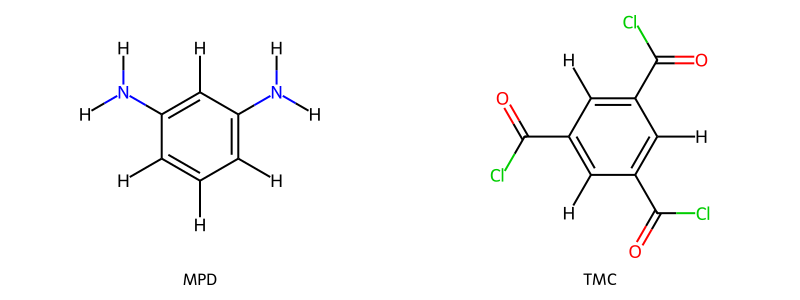

In [3]:
reactant_smiles : dict[str, Smiles] = {
    'MPD' : 'c1ccc(N)cc1N',
    'TMC' : 'c1c(C(=O)Cl)cc(C(=O)Cl)cc1(C(=O)Cl)',
}
monomers : dict[str, Chem.Mol] = {name : explicit_mol(smiles) for name, smiles in reactant_smiles.items()}

MolsToGridImage(monomers.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=list(monomers.keys()))

## Define polycondensation reaction template

### Assemble reaction from target functional groups, in this case an amide and an acyl chloridem

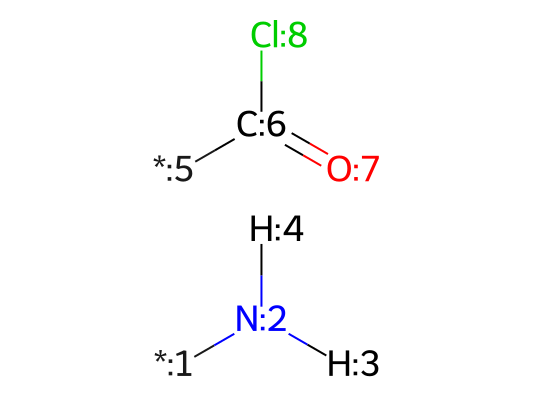

In [4]:
from polymerist.rdutils.reactions import ReactionAssembler

assem = ReactionAssembler(
    reactive_groups=[
        Chem.MolFromSmarts('*-N(-[H])(-[H])'), # amine group
        Chem.MolFromSmarts('*-C(=O)-Cl'),      # acyl chloride group
    ],
    byproducts=[Chem.MolFromSmarts('[H]-[Cl]')], # eject and unmap HCl byproduct
    rxn_name='amide-acyl chloride condensation',
)
display(assem.reactants)

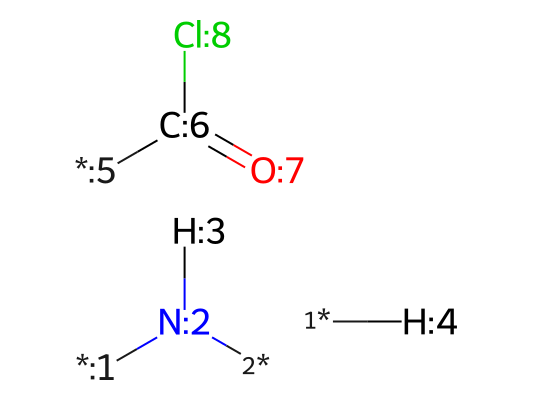

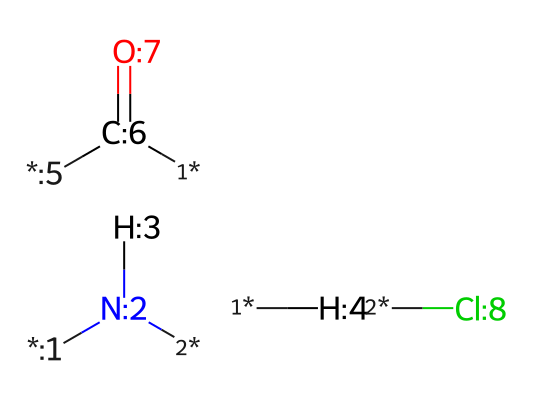

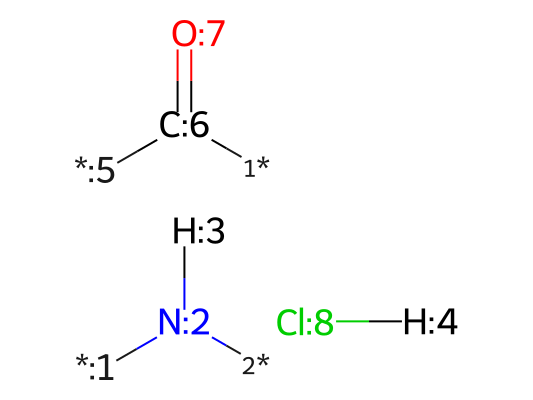

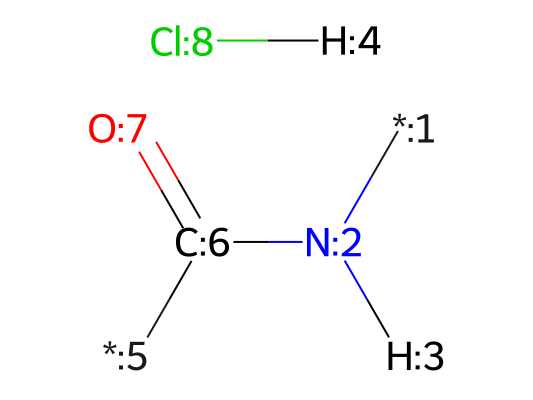

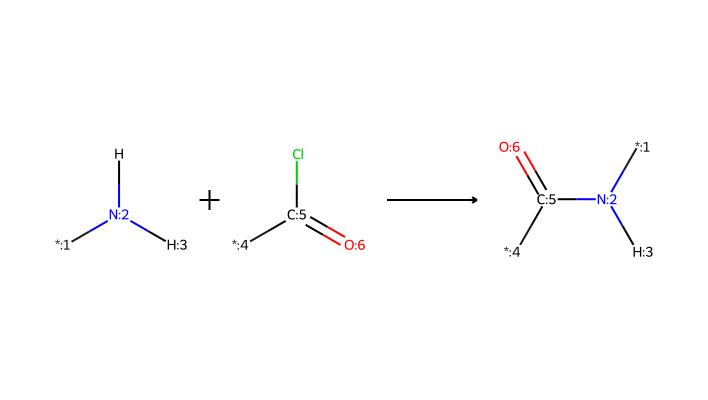

In [5]:
assem.bond_derangement = {
    4 : (2, 8), # H:4, which was connected to C:2, should reconnect to Cl:8
    6 : (8, 2), # C:6, which was connected to Cl:8, should reconnect to C:2
} # note that this forms a closed bond cycle, since atoms 2 and 8 each gain and lose 1 bond, respectively, amounting to no net valence change

rxn = assem.assemble_rxn(show_steps=True)
rxn_smarts = rxn.to_smarts()
display(rxn)

### Enumerate all possible repeat unit fragments from monomers and reaction template

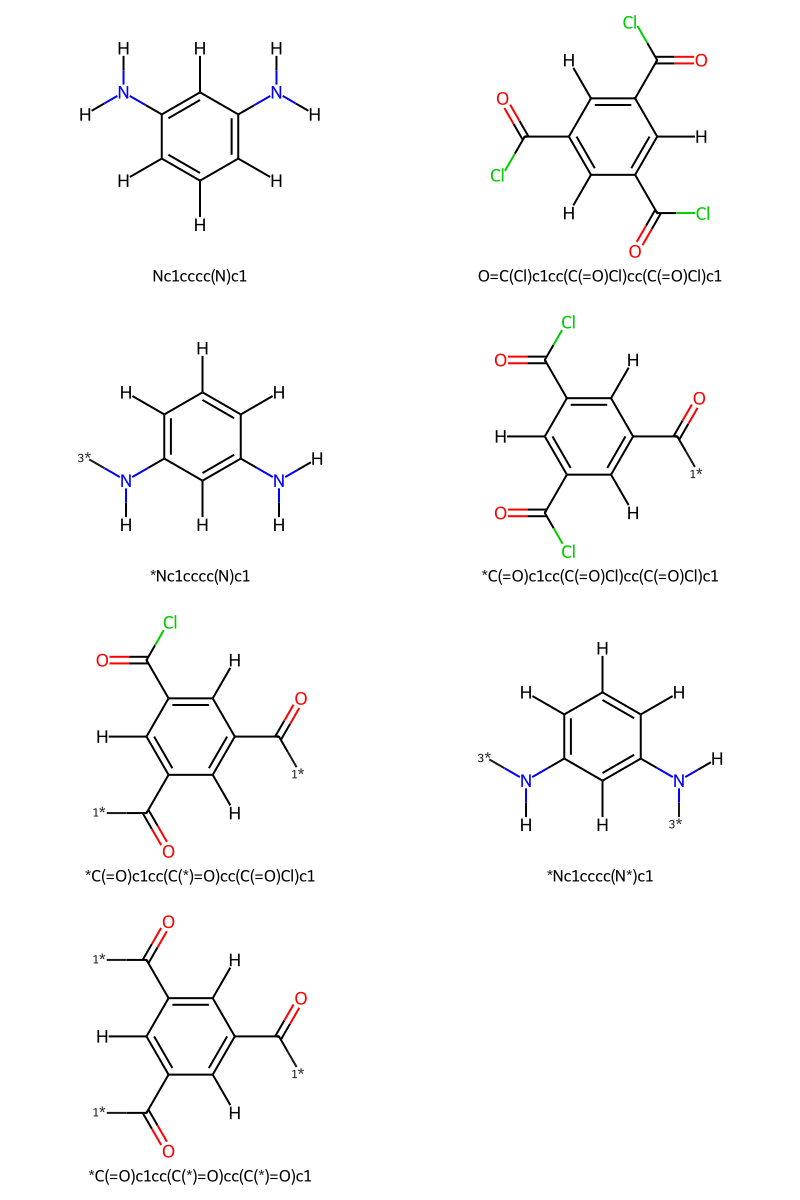

In [8]:
from polymerist.rdutils.reactions import AnnotatedReaction
from polymerist.rdutils.reactions import PolymerizationReactor, CutMinimumCostBondsStrategy


reactor = PolymerizationReactor(
    rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts),
    fragment_strategy=CutMinimumCostBondsStrategy()
)
fragments = reactor.propagate_pooled(monomers.values(), sanitize_ops=SANITIZE_ALL, aromaticity_model=AROMATICITY_MDL)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=list(fragments.keys()))

### Generate informative named and monomer specification-compliant SMARTS for each fragment

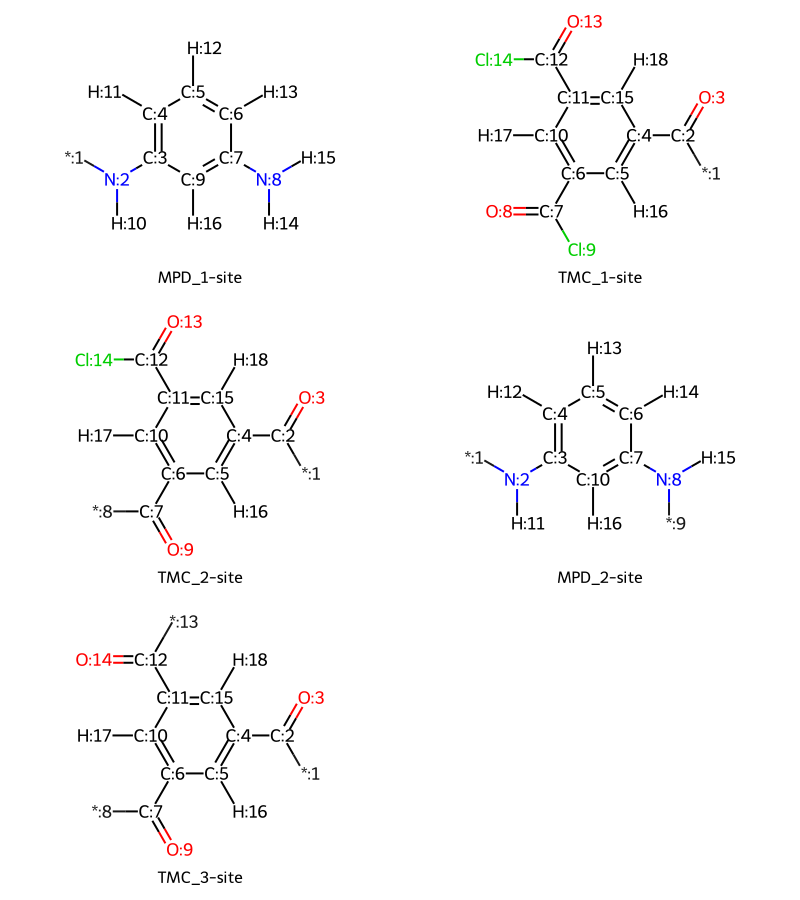

In [10]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports


named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    query_mol = Chem.MolFromSmarts(canon_smiles) # important! need to makes SMARTS-based query mol to check for substructure - ports on returned SMILES-based mols are not treated correctly as wild-type atoms
    parent_mol_name = '-'.join(name for name, monomer in monomers.items() if monomer.HasSubstructMatch(query_mol))
    
    named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=list(monogrp.monomers.keys()))

## Use fragments to assemble a polymer

In [11]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_rdkit_pdb


# NOTE: unless you explicitly provide term group orientations, the builder will automatically
# choose the first two terminal groups as head and tail, respectively, in whatever order they appear,
# or the only terminal group twice if just one is provided
monogrp.term_orient = {
    'head' : 'MPD_1-site',
    'tail' : 'TMC_1-site',
}

chain = build_linear_polymer(
    monomers=monogrp,
    sequence='AB', # will alternate TMC and MPD 2-site monomers after the MPD head group (A and B correspond to the order these monomers appear in the monomer group)
    n_monomers=30,
    energy_minimize=False, # this will make PDB generation much faster but give less physical structures
)
chain.visualize()

[21:21:43] WARNING: not removing hydrogen atom with dummy atom neighbors


3Dmol.js failed to load for some reason. Please check your browser console for error messages.